In [36]:
import sys, os

# Add src directory to Python path
sys.path.append(os.path.abspath("../src"))

from utils import preprocess_maf, load_maf, save_plot
import pandas as pd


# Load raw MAF file
maf_raw = load_maf("../data/cohortMAF.2025-07-11.maf")

# Preprocess to remove silent mutations, etc.
maf = preprocess_maf(maf_raw)


In [3]:
# Extract only sample–gene pairs
sample_gene_df = maf[['Tumor_Sample_Barcode', 'Hugo_Symbol']].copy()

# Standardize formatting
sample_gene_df['Tumor_Sample_Barcode'] = sample_gene_df['Tumor_Sample_Barcode'].str.strip()
sample_gene_df['Hugo_Symbol'] = sample_gene_df['Hugo_Symbol'].str.strip().str.upper()

# Drop duplicates and assign mutation indicator
sample_gene_df = sample_gene_df.drop_duplicates()
sample_gene_df['Mutated'] = 1

# Create mutation matrix (samples × genes)
mutation_matrix = (
    sample_gene_df
    .pivot_table(index='Tumor_Sample_Barcode', 
                 columns='Hugo_Symbol', 
                 values='Mutated', 
                 fill_value=0)
)

mutation_matrix.head()


Hugo_Symbol,A1BG,A1CF,A2M,A2ML1,A4GALT,AAAS,AACS,AADAC,AADACL2,AADACL3,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZZEF1,ZZZ3
Tumor_Sample_Barcode,,,,,,,,,,,,,,,,,,,,,
358296ad-e2a7-40cd-849e-8590fd_D6_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48d1b543-dbf6-4594-b34a-d0e30a_D6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-3C-AAAU-01A-11D-A41F-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-3C-AALI-01A-11D-A41F-09,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
TCGA-3C-AALJ-01A-31D-A41F-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Load subtype labels
subtypes = pd.read_csv("../data/tcga_brca_subtypes.csv")
subtypes.columns = ['Short_Barcode', 'Subtype']

# Preview
subtypes.head()

,Short_Barcode,Subtype
0,TCGA-3C-AAAU,LumA
1,TCGA-3C-AALI,Her2
2,TCGA-3C-AALJ,LumB
3,TCGA-3C-AALK,LumA
4,TCGA-4H-AAAK,LumA


In [6]:
# Reset index and keep Tumor_Sample_Barcode as a column
mutation_matrix = mutation_matrix.reset_index()

# Extract short-form TCGA barcodes (e.g., TCGA-XX-XXXX)
mutation_matrix['Short_Barcode'] = mutation_matrix['Tumor_Sample_Barcode'].str.extract(r'(^TCGA-\w{2}-\w{4})')

# Drop rows where Short_Barcode could not be extracted (i.e., non-TCGA samples)
mutation_matrix = mutation_matrix[mutation_matrix['Short_Barcode'].notna()]

# Optional: reset index again after filtering
mutation_matrix = mutation_matrix.reset_index(drop=True)

# Confirm it worked
print(mutation_matrix[['Tumor_Sample_Barcode', 'Short_Barcode']].head())

Hugo_Symbol          Tumor_Sample_Barcode Short_Barcode
0            TCGA-3C-AAAU-01A-11D-A41F-09  TCGA-3C-AAAU
1            TCGA-3C-AALI-01A-11D-A41F-09  TCGA-3C-AALI
2            TCGA-3C-AALJ-01A-31D-A41F-09  TCGA-3C-AALJ
3            TCGA-3C-AALK-01A-11D-A41F-09  TCGA-3C-AALK
4            TCGA-4H-AAAK-01A-12D-A41F-09  TCGA-4H-AAAK


In [7]:
matching = mutation_matrix['Short_Barcode'].isin(subtypes['Short_Barcode'])
print("Matching barcodes:", matching.sum(), "/", len(mutation_matrix))



Matching barcodes: 587 / 593


In [8]:
merged_df = pd.merge(mutation_matrix, subtypes, left_on="Short_Barcode", right_on="Short_Barcode", how="inner")
merged_df = merged_df.drop(columns=["Tumor_Sample_Barcode", "Short_Barcode", "Short_Barcode"])

print("Subtype counts:")
print(merged_df["Subtype"].value_counts())


Subtype counts:
Subtype
LumA      299
LumB      118
Basal     106
Her2       46
Normal     18
Name: count, dtype: int64


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Split features and labels
X = merged_df.drop(columns=["Subtype"])
y = merged_df["Subtype"]

# Encode string labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


Training samples: 410
Testing samples: 177


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd
import os

# ✅ 1. Train a model
X = X.drop(columns=[col for col in X.columns if col.lower() in ['index', 'barcode', 'tumor_sample_barcode']], errors='ignore')
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# ✅ 2. Predict on test set
y_pred = model.predict(X_test)

# ✅ 3. Generate and save classification report
report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Ensure the directory exists
os.makedirs("../results", exist_ok=True)

# Save report to CSV
report_df.to_csv("../results/05_classification_report.csv")
print("✅ Classification report saved to: results/05_classification_report.csv")


✅ Classification report saved to: results/05_classification_report.csv


/Users/aman/bioinformatics-portfolio/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/aman/bioinformatics-portfolio/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/aman/bioinformatics-portfolio/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

Text(0.5, 1.0, 'Subtype Distribution')

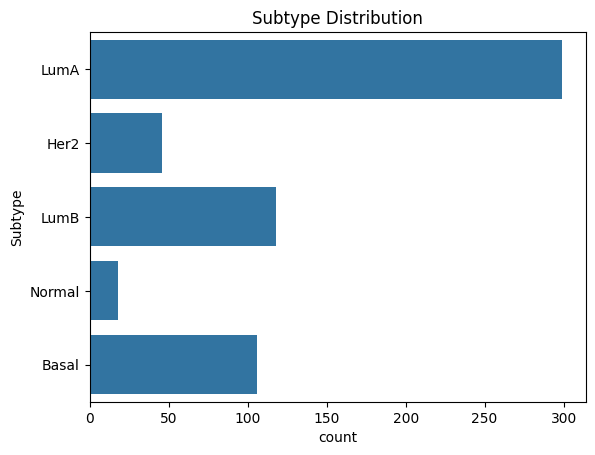

In [27]:
import seaborn as sns
sns.countplot(y)
plt.title("Subtype Distribution")

[✅] Saved: Confusion Matrix → ../figures/07-Confusion_Matrix.png


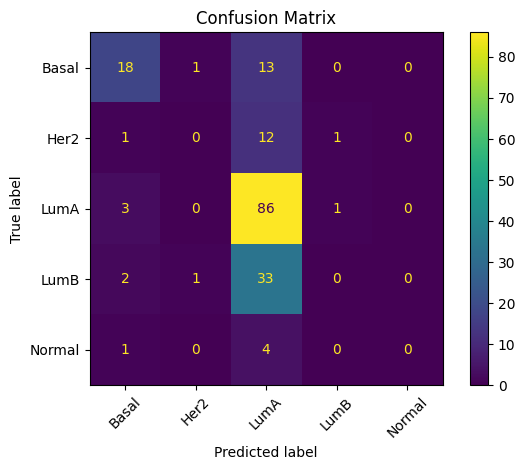

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=le.classes_, xticks_rotation=45)
plt.title("Confusion Matrix")
save_plot("Confusion_Matrix", step="07", title="Confusion Matrix")
plt.show()


/var/folders/dw/cp1c7tm95pldv_d3y5p478280000gn/T/ipykernel_54593/2045925435.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Gene', data=feat_df, palette='mako')


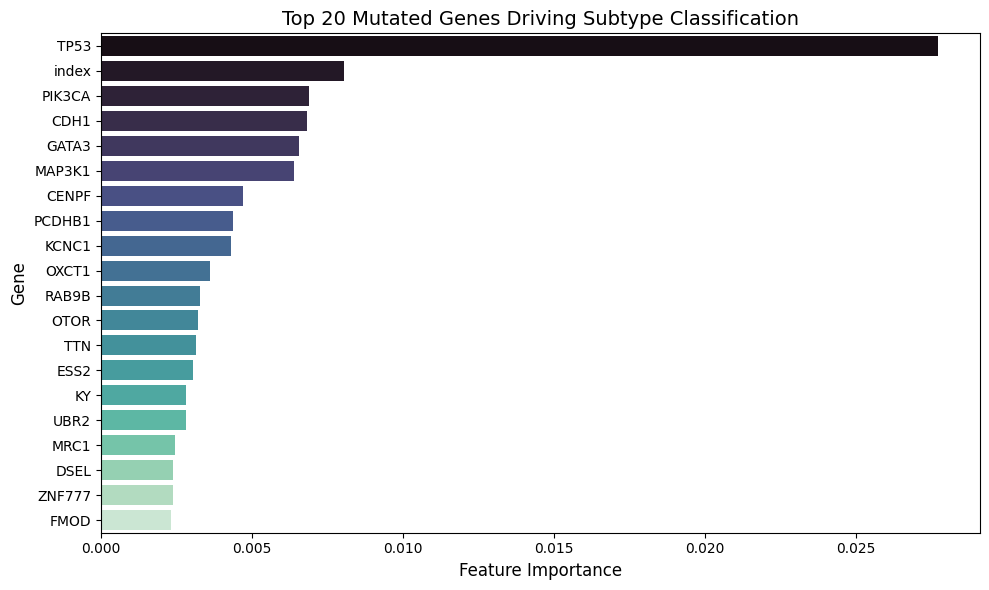

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature names (match to X_train)
feature_names = X_train.columns
importances = model.feature_importances_

# Create DataFrame of gene importances
feat_df = pd.DataFrame({'Gene': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Gene', data=feat_df, palette='mako')
plt.title("Top 20 Mutated Genes Driving Subtype Classification", fontsize=14)
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Gene", fontsize=12)
plt.tight_layout()
plt.savefig("../figures/08-feature_importance.png", dpi=300)
plt.show()